In [1]:
import tensorflow as tf
import os
import subprocess
import tensorflow_io as tfio
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten
from tensorflow import keras
from tensorflow.keras import layers


In [2]:
# NOTE: You will likely need to change Rivanna's version of numpy to be compatible with tensorflow. 
# You will likely also have to install tensorflow_io. 
# Make sure to restart the kernal after you finish the pip install. 
#!pip install numpy==1.23

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.23.0-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an EnvironmentError: [Errno 16] Device or resource busy: '.nfs00000004c8a4d48000002600'



# Convert webm to .wav file
Using the FFmpeg application, I ran a subprocess to iteratively convert the .webm files to .wav files

In [2]:
# directory = os.fsencode('C:\\Users\\alexa\\DS6050\\Data')
# path = 'C:\\Users\\alexa\\DS6050\\Data'
# for file in os.listdir(directory):
#     filename = os.fsdecode(file)
#     if filename.endswith('webm'):
#         subprocess.run(['FFmpeg','-i',os.path.join(path,filename),'C:/Users/alexa/DS6050/Data/'+filename+'.wav'])
        

Then I removed the .webm from the file name

In [3]:
# directory = os.fsencode('C:\\Users\\alexa\\DS6050\\Data')
# path = 'C:\\Users\\alexa\\DS6050\\Data'
# files = []
# for file in os.listdir(directory):
#     filename = os.fsdecode(file)
#     if filename.endswith('wav'):
#         os.rename(os.path.join(path,filename),os.path.join(path,filename.replace('.webm','')))
#         files.append(filename)

Get the status of the patient for a corresponding audio file. For now, just get the healthy and COVID-19 cases. 

In [4]:
label_df = pd.read_csv('/scratch/kzr3fb/Data/metadata_compiled.csv')[['uuid','status']]

Break out the labels and audio files into healthy and covid. 

In [5]:
path = '/scratch/kzr3fb/Data/'
healthy = list(label_df.loc[label_df['status']=='healthy'].uuid)
healthy = [path + '\\' + x + '.wav' for x in healthy]
covid = list(label_df.loc[label_df['status']=='COVID-19'].uuid)
covid = [path + '\\' + x + '.wav' for x in covid]

Convert both lists to list_files objects. 

In [ ]:
healthy_files = tf.data.Dataset.list_files(healthy)
covid_files = tf.data.Dataset.list_files(covid)

Zip together the audio file path with the data label for whether the audio file corresponds to a person with COVID (1) or is healthy (0)

In [8]:
covid=tf.data.Dataset.zip((covid_files,tf.data.Dataset.from_tensor_slices(tf.ones(len(covid_files)))))
healthy=tf.data.Dataset.zip((healthy_files,tf.data.Dataset.from_tensor_slices(tf.zeros(len(healthy_files)))))
data=covid.concatenate(healthy)

Read in the sound data from the wav files.

In [9]:
def load_wav(filename):
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    return wav, sample_rate

In [10]:
def preprocess(path, label):
    # call the wav data load function
    wav, sample_rate = load_wav(path)
    # Do the short-time Fourier Transform. 
    spectrogram = tf.signal.stft(wav, frame_length = 2048, frame_step = 512)
    # take absolute value of spectrogram
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    spectrogram = tf.image.resize(spectrogram,[512,512])
    rgb_spectrogram = tf.image.grayscale_to_rgb(spectrogram, name=None)
    return rgb_spectrogram, label

In [14]:
filepath,label=covid.shuffle(buffer_size=len(covid)).as_numpy_iterator().next()
spectrogram,label=preprocess(filepath,label)

In [15]:
spectrogram.shape

TensorShape([46, 257, 3])

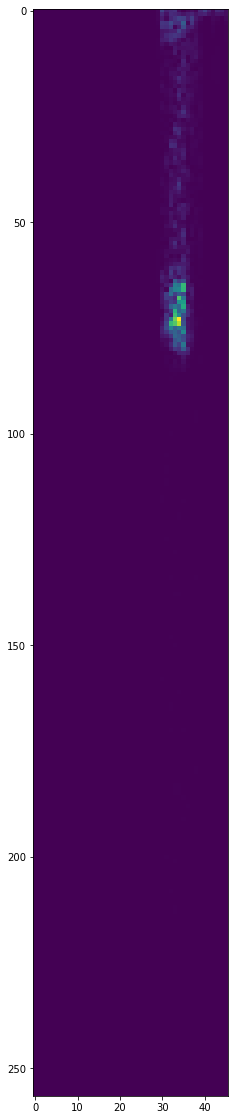

In [16]:
plt.figure(figsize=(10,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [17]:
data = data.map(preprocess).cache().shuffle(buffer_size=len(covid)+len(healthy)).batch(16).prefetch(8)

In [18]:
len(data)

46

In [21]:
train = data.take(75)
test = data.skip(75).take(25)
samples,labels=train.as_numpy_iterator().next()
samples.shape[1:4]

(46, 257, 3)

In [22]:
# model=Sequential()
# model.add(Conv2D(16,(3,3),activation='relu',input_shape=samples.shape[1:4]))
# model.add(Conv2D(16,(3,3),activation='relu'))
# model.add(Flatten())
# model.add(Dense(128,activation='relu'))
# model.add(Dense(1,activation='sigmoid'))
inputs = keras.Input(shape=samples.shape[1:4])

base_model = keras.applications.EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_tensor=inputs,
    input_shape=samples.shape[1:4],
    pooling=None,
    classes=2,
    classifier_activation="sigmoid",
    include_preprocessing=True,
)

base_model.trainable = False

# model = Sequential([base_model,
#                 layers.MaxPooling2D(),
#                 layers.Flatten(),
#                 layers.Dense(10, activation='relu'),
#                 layers.Dense(1)])

x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

In [23]:
model.compile('Adam',loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [24]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 46, 257, 3)]      0         
                                                                 
 efficientnetv2-s (Function  (None, 2, 9, 1280)        20331360  
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 20332641 (77.56 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 20331360 (77.56 MB)
_________________________________________________________________


In [25]:
hist=model.fit(train,epochs=5,validation_data=test)

Epoch 1/5
75/75 [==============================] - 44s 496ms/step - loss: 0.2971 - accuracy: 0.0000e+00 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.3309 - val_accuracy: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/5
75/75 [==============================] - 37s 489ms/step - loss: 0.3108 - accuracy: 0.0000e+00 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.3155 - val_accuracy: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/5
75/75 [==============================] - 36s 488ms/step - loss: 0.2829 - accuracy: 0.0000e+00 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.2640 - val_accuracy: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/5
75/75 [==============================] - 36s 487ms/step - loss: 0.3127 - accuracy: 0.0000e+00 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.3001 - val_accuracy: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/

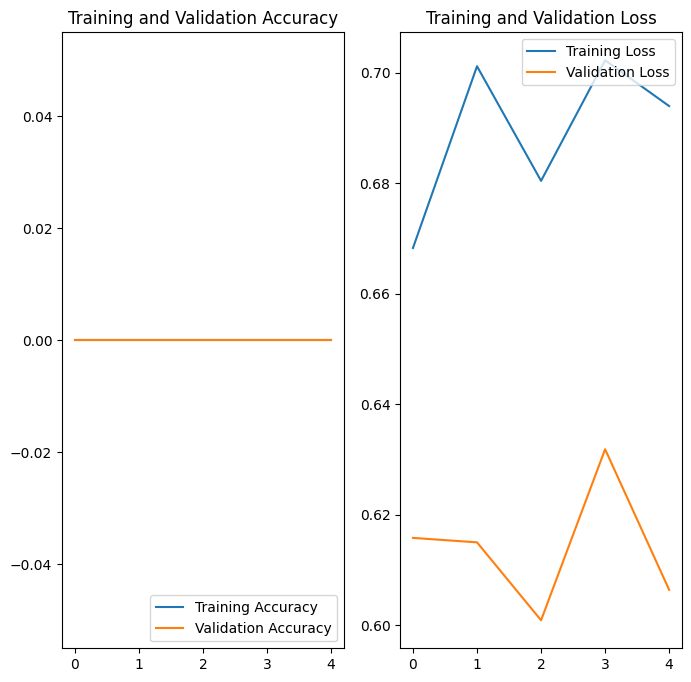

In [22]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(5)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()